In [ ]:
!pip install statsmodels

# 데이터를 통해 forward, backward, stepwise 모두 진행

In [2]:
import pandas as pd
missing_to_median=pd.read_csv("data1.csv")    
missing_to_drop = pd.read_csv("data2.csv")

data_median = missing_to_median.drop("TARGET", axis = 1)
target_median = missing_to_median["TARGET"]
data_drop = missing_to_drop.drop("TARGET", axis = 1)
target_drop = missing_to_drop["TARGET"]


In [2]:
missing_to_median

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_INCOME_TYPE_1.0,NAME_INCOME_TYPE_2.0,NAME_INCOME_TYPE_3.0,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3
0,1,0,0,0,1,0.0,0.097012,-0.209713,-0.061953,0.0,...,0.0,0.0,0.0,-0.279894,0.0,0,0,0,1,0
1,0,0,1,0,0,0.0,0.341907,1.412120,0.531827,1.0,...,0.0,0.0,0.0,-0.279894,-0.5,0,1,0,0,0
2,0,1,0,1,1,0.0,-0.392777,-0.706368,-1.031098,0.0,...,0.0,0.0,0.0,-0.279894,-0.5,0,0,0,1,0
3,0,0,1,0,1,0.0,-0.147882,-0.381450,0.207240,0.0,...,0.0,0.0,0.0,-0.279894,0.0,0,0,0,0,0
4,0,0,0,0,1,0.0,-0.196861,-0.015141,-0.215015,0.0,...,0.0,0.0,0.0,-0.279894,-0.5,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210206,0,0,1,0,1,0.0,-0.082577,-0.346272,-0.526482,0.0,...,0.0,0.0,0.0,-0.279894,0.0,0,0,0,0,1
210207,0,0,0,0,0,0.0,-0.066251,-0.487480,0.092323,0.0,...,0.0,0.0,0.0,-0.279894,0.0,0,0,0,0,1
210208,0,0,1,0,1,0.0,-0.082577,0.285971,0.223032,0.0,...,0.0,0.0,1.0,-0.279894,0.0,0,0,0,0,1
210209,1,0,1,0,1,0.0,-0.017272,-0.276441,-0.304665,0.0,...,0.0,0.0,0.0,-0.279894,-0.5,1,0,0,0,0


In [ ]:
# # 데이터 샘플링 (예: 20% 샘플 사용)
# data_sampled = data.sample(frac=0.3, random_state=42)  # 10% 샘플링
# target_sampled = target.loc[data_sampled.index]

## 각 모델들 정의

In [5]:
from sklearn.naive_bayes import GaussianNB
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer

def forward_selection(data, target, cv=3):
    # Naive Bayes 모델 정의
    model = GaussianNB()
    
    # Stratified K-Fold 설정
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # roc_auc 스코어 설정
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')
    
    # SequentialFeatureSelector 설정
    sfs = SequentialFeatureSelector(
        model,
        k_features="best",         # 최적의 feature 수를 자동으로 선택
        forward=True,              # Forward Selection
        floating=False,            # Floating 옵션 비활성화
        scoring=roc_auc_scorer,    # 모델 평가 기준을 roc_auc로 설정
        cv=cv_strategy,            # 계층적 KFold 사용
        n_jobs=5                # 병렬 처리
    )

    # Forward Selection 실행
    print("Naive Bayes로 Forward Selection 시작\n")
    all_scores = []  # 각 단계의 성능 기록

    for feature_count in range(1, data.shape[1] + 1):
        sfs.k_features = feature_count
        sfs = sfs.fit(data.values, target.values)

        # 선택된 Feature와 평가 점수 기록
        selected_features = list(data.columns[list(sfs.k_feature_idx_)])
        mean_score = sfs.k_score_
        all_scores.append((feature_count, selected_features, mean_score))

        # 현재 단계 출력
        print(f"Step {feature_count}: Selected Features - {selected_features}")
        print(f"    Mean ROC AUC Score: {mean_score:.4f}\n")

    # 최종 결과 출력
    print("최종 선택된 Features:")
    final_features = data.columns[list(sfs.k_feature_idx_)]
    print(final_features.tolist())
    
    return all_scores


In [ ]:
def backward_selection(data, target, cv=5):
    # Logistic Regression 모델 정의
    model = LogisticRegression(max_iter=1000, random_state=42)

    # StratifiedKFold를 사용하여 교차 검증 설정
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # roc_auc 스코어 설정
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # SequentialFeatureSelector 설정
    sfs = SequentialFeatureSelector(
        model,
        k_features="best",         # 최적의 feature 수를 자동으로 선택
        forward=False,             # Backward Selection
        floating=False,            # Floating 옵션 비활성화
        scoring=roc_auc_scorer,    # 모델 평가 기준을 roc_auc로 설정
        cv=cv_strategy,            # 계층적 KFold 사용
        n_jobs=-1                  # 병렬 처리
    )

    # Backward Selection 실행
    print("Backward Selection 시작\n")
    all_scores = []  # 각 단계의 성능 기록

    for feature_count in range(data.shape[1], 0, -1):
        sfs.k_features = feature_count
        sfs = sfs.fit(data.values, target.values)

        # 선택된 Feature와 평가 점수 기록
        selected_features = list(data.columns[list(sfs.k_feature_idx_)])
        mean_score = sfs.k_score_
        all_scores.append((feature_count, selected_features, mean_score))

        # 현재 단계 출력
        print(f"Step {data.shape[1] - feature_count + 1}: Selected Features - {selected_features}")
        print(f"    Mean ROC AUC Score: {mean_score:.4f}\n")

    # 최종 결과 출력
    print("최종 선택된 Features:")
    final_features = data.columns[list(sfs.k_feature_idx_)]
    print(final_features.tolist())
    
    return all_scores


In [ ]:
def stepwise_selection(data, target, cv=5):
    # Logistic Regression 모델 정의
    model = LogisticRegression(max_iter=1000, random_state=42)

    # StratifiedKFold를 사용하여 교차 검증 설정
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # roc_auc 스코어 설정
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # SequentialFeatureSelector 설정
    sfs = SequentialFeatureSelector(
        model,
        k_features="best",         # 최적의 feature 수를 자동으로 선택
        forward=True,              # Forward Selection 기반
        floating=True,             # Stepwise Selection 활성화
        scoring=roc_auc_scorer,    # 모델 평가 기준을 roc_auc로 설정
        cv=cv_strategy,            # 계층적 KFold 사용
        n_jobs=-1                  # 병렬 처리
    )

    # Stepwise Selection 실행
    print("Stepwise Selection 시작\n")
    all_scores = []  # 각 단계의 성능 기록

    for feature_count in range(1, data.shape[1] + 1):
        sfs.k_features = feature_count
        sfs = sfs.fit(data.values, target.values)

        # 선택된 Feature와 평가 점수 기록
        selected_features = list(data.columns[list(sfs.k_feature_idx_)])
        mean_score = sfs.k_score_
        all_scores.append((feature_count, selected_features, mean_score))

        # 현재 단계 출력
        print(f"Step {feature_count}: Selected Features - {selected_features}")
        print(f"    Mean ROC AUC Score: {mean_score:.4f}\n")

    # 최종 결과 출력
    print("최종 선택된 Features:")
    final_features = data.columns[list(sfs.k_feature_idx_)]
    print(final_features.tolist())
    
    return all_scores


## 실행결과

In [ ]:

# Forward Selection 실행
selected_features = forward_selection(data_drop, target_drop)

c:\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Naive Bayes로 Forward Selection 시작



c:\Python312\Lib\site-packages\mlxtend\feature_selection\sequential_feature_selector.py:800: RuntimeWarning: Mean of empty slice
  all_avg_scores.append(np.nanmean(cv_scores))


Step 1: Selected Features - ['FLAG_MOBIL']
    Mean ROC AUC Score: nan

Step 2: Selected Features - ['FLAG_MOBIL', 'EXT_SOURCE_2']
    Mean ROC AUC Score: 0.6556

Step 3: Selected Features - ['DAYS_EMPLOYED', 'FLAG_MOBIL', 'EXT_SOURCE_2']
    Mean ROC AUC Score: 0.6652

Step 4: Selected Features - ['NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'EXT_SOURCE_2']
    Mean ROC AUC Score: 0.6690

Step 5: Selected Features - ['NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2']
    Mean ROC AUC Score: 0.6708

Step 6: Selected Features - ['NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE']
    Mean ROC AUC Score: 0.6732

Step 7: Selected Features - ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE']
    Mean ROC AUC Score: 0.6758

Step 8: Selected Features - ['CODE_GENDER', '

In [ ]:
# backward_selection 실행
backward_selection(data_median, target_median)

In [ ]:
stepwise_selection(data_median, target_median)

Selected features: ('NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',

## 변수 선택 전 기본 모델 성능 확인

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(data_median, target_median, test_size=0.3, random_state=42)


array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [14]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# statsmodels 학습모델 구축
lr = sm.Logit(y_train, X_train)

# 모델 적합
result = lr.fit()
result.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [20]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

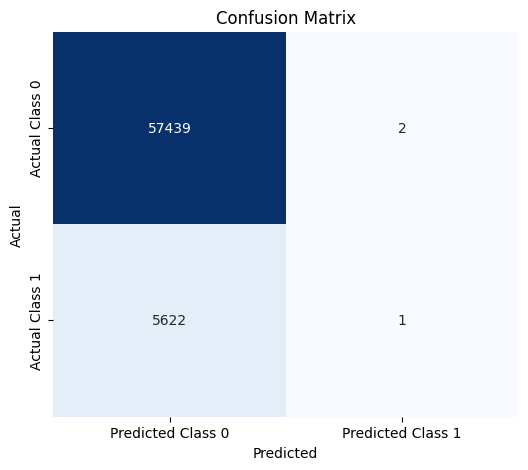


Evaluation Metrics:
Recall: 0.911
Precision: 0.859
F1 Score: 0.868


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

# 2. 예측
y_pred = model.predict(X_test)  # X_test로 예측값 생성
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted Class 0', 'Predicted Class 1'], 
            yticklabels=['Actual Class 0', 'Actual Class 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Recall, Precision, F1 Score
recall = recall_score(y_test, y_pred, average='weighted')   # 'weighted'는 클래스 불균형 고려
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nEvaluation Metrics:")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")